In [130]:
import pandas as pd
import openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False ## 마이나스 '-' 표시 제대로 출력
 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [131]:
# 한글 폰트
import matplotlib.font_manager
font_list = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
print([matplotlib.font_manager.FontProperties(fname=font).get_name() for font in font_list if 'Nanum' in font][:10])
plt.rcParams["font.family"] = 'NanumSquareRound'
plt.rcParams["figure.figsize"] = (10,5)

['NanumBarunpen', 'NanumSquareOTF_ac', 'NanumGothic', 'NanumSquareOTF', 'NanumBarunpen', 'NanumBarunGothic', 'NanumSquareOTF', 'NanumSquareOTF_ac', 'NanumSquare_ac', 'NanumMyeongjo']


In [132]:
# get Data file
file_path = '../data/output/특정품목 조달 내역_2020-2022.xlsx'
data = pd.read_excel(file_path, index_col=0)
print(data.head(5))

  수요기관지역명 계약건명 수요기관구분      장비금액       계약금액    냉방용량    난방용량         날짜
0     경기도  NaN   국가기관   6034460    6034460    40.2    45.4 2020-06-08
1   서울특별시  NaN   국가기관  84395000   84395000  1013.2  1140.2 2020-10-13
2   서울특별시  NaN   국가기관     94336    2162336   249.9   281.6 2020-10-21
3   서울특별시  NaN    공기업  43490000  264110930   710.3   798.5 2020-02-26
4   서울특별시  NaN   교육기관  33878539  140333009   674.3   757.9 2020-03-24


In [133]:
# make new columns
data['용량'] = data[['냉방용량','난방용량']].max(axis=1)

# delete the row with the 0 cost
data = data[data['계약금액'] != 0]
data = data[data['장비금액'] != 0]
data = data[data['용량'] != 0]

# make new columns
data['장비금액비율'] = data['장비금액']/data['계약금액']
data = data[data['장비금액비율'] < 0.8]


In [134]:

# calculate the lower and upper bounds based on the specified quantile value
q1 = data['용량'].quantile(0.25)
q3 = data['용량'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

In [135]:
# filter out the outlier rows
data = data[(data['용량'] >= lower_bound) & (data['용량'] <= upper_bound)]

In [136]:
def getLinearRegression(x_column: str , y_column: str , data: pd.DataFrame):
    # create a linear regression model
    reg = LinearRegression().fit(data[[x_column]], data[[y_column]])

    # use statsmodels to identify influential points
    influence = sm.OLS(data[y_column], sm.add_constant(data[x_column])).fit().get_influence()
    outliers = influence.summary_frame().loc[influence.summary_frame().cooks_d > 4/len(data)]

    # remove the influential points from the dataframe
    data_remove_outlier = data.drop(outliers.index)

    # re-fit the linear regression model without the influential points
    reg = LinearRegression().fit(data_remove_outlier[[x_column]], data_remove_outlier[[y_column]])

    # print the coefficients
    print('Intercept:', reg.intercept_)
    print('Coefficient:', reg.coef_[0])
    return reg, data_remove_outlier

In [137]:
def drawLinearRegressionPlot(regression_model: LinearRegression, x_column:str, y_column:str, data: pd.DataFrame):
    
    # plot the scatter plot and linear regression line
    fig, ax = plt.subplots()
    ax.scatter(data[x_column], data[y_column], color='blue')
    ax.plot(data[x_column], regression_model.predict(data[[x_column]]), color='red')
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)
    ax.set_title('Scatter plot with linear regression line')
    plt.show()

Intercept: [1335719.76906264]
Coefficient: [245184.37368054]


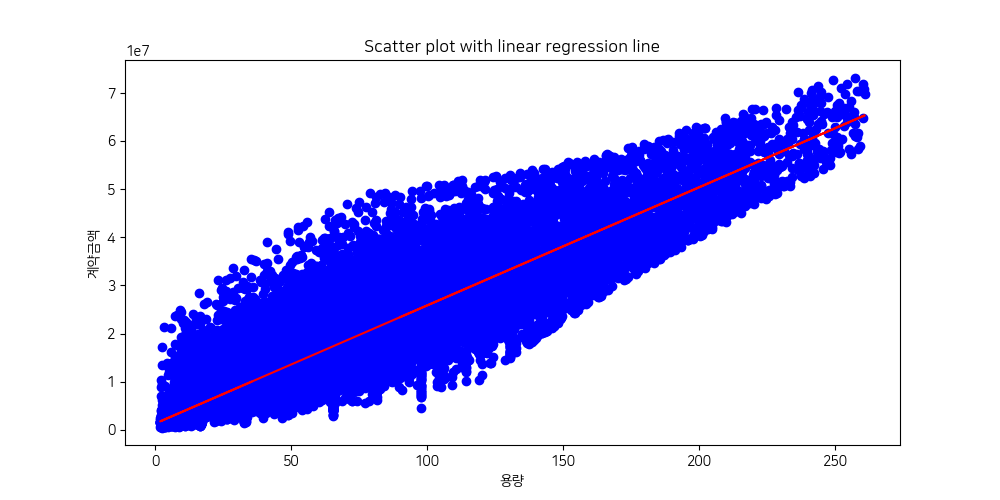

In [138]:
# create a linear regression model
reg, data_outlier = getLinearRegression(x_column='용량', y_column='계약금액', data=data)
# draw a linaer line
%matplotlib widget
drawLinearRegressionPlot(regression_model=reg, x_column='용량', y_column='계약금액', data=data_outlier)


In [139]:
# create a linear regression model
reg, data_outlier = getLinearRegression(x_column='용량', y_column='장비금액비율', data=data)
# draw a linaer line
%matplotlib widget
drawLinearRegressionPlot(regression_model=reg, x_column='용량', y_column='장비금액비율', data=data_outlier)

In [ ]:
# create boxplot
stats = data_outlier.groupby('수요기관지역명').agg({'장비금액비율': ['mean'], '계약금액':['mean']})
print(stats)

           장비금액비율          계약금액
             mean          mean
수요기관지역명                        
강원도      0.259135  1.722084e+07
경기도      0.249315  1.792076e+07
경상남도     0.239539  1.602699e+07
경상북도     0.266369  1.543746e+07
광주광역시    0.269292  1.460919e+07
대구광역시    0.260620  1.502939e+07
대전광역시    0.267211  1.493909e+07
부산광역시    0.249935  1.703585e+07
서울특별시    0.241390  1.943095e+07
세종특별자치시  0.251805  1.619976e+07
울산광역시    0.274790  1.431639e+07
인천광역시    0.239081  1.986403e+07
전라남도     0.254017  1.644106e+07
전라북도     0.264391  1.641121e+07
제주특별자치도  0.257590  1.408699e+07
충청남도     0.267325  1.485855e+07
충청북도     0.276046  1.514547e+07


In [ ]:
data_notna = data.dropna(axis=0, subset=['계약건명'])
data_ele = data_notna[data_notna['계약건명'].str.contains('전기')]
data_gas = data_notna[data_notna['계약건명'].str.contains('가스')]
data_geo = data_notna[data_notna['계약건명'].str.contains('지열')]

Intercept: [2055017.65243682]
Coefficient: [239739.69856471]


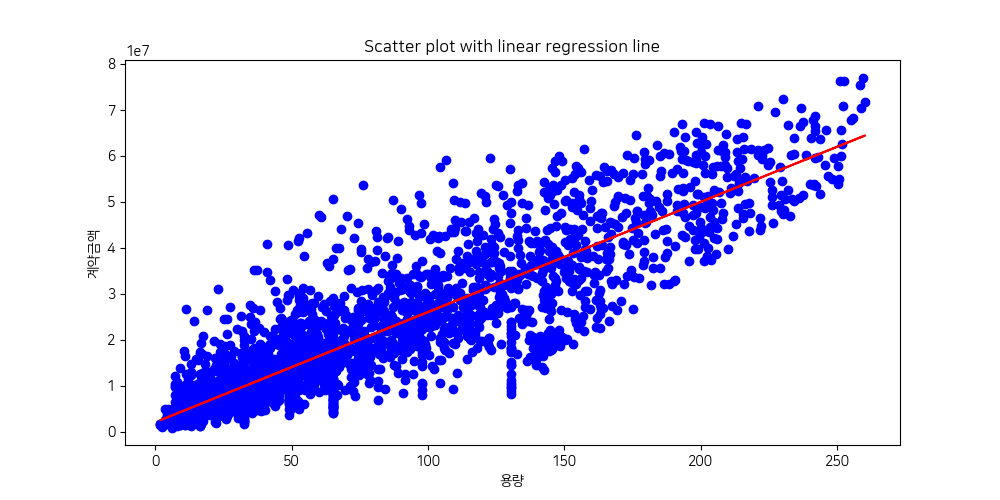

In [ ]:
# create a linear regression model
reg, data_outlier = getLinearRegression(x_column='용량', y_column='계약금액', data=data_ele)
# draw a linaer line
%matplotlib widget
drawLinearRegressionPlot(regression_model=reg, x_column='용량', y_column='계약금액', data=data_outlier)

Intercept: [0.24789109]
Coefficient: [5.09947354e-05]


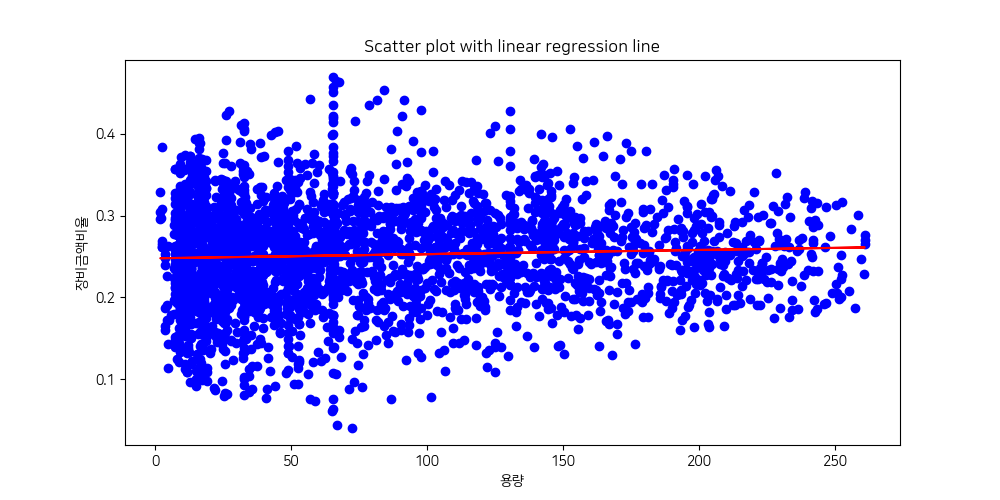

In [ ]:
# create a linear regression model
reg, data_outlier = getLinearRegression(x_column='용량', y_column='장비금액비율', data=data_ele)
# draw a linaer line
%matplotlib widget
drawLinearRegressionPlot(regression_model=reg, x_column='용량', y_column='장비금액비율', data=data_outlier)

In [ ]:
# create boxplot
stats = data_outlier.groupby('수요기관지역명').agg({'장비금액비율': ['mean'], '계약금액':['mean']})
print(stats)

           장비금액비율          계약금액
             mean          mean
수요기관지역명                        
강원도      0.258851  2.198108e+07
경기도      0.240003  2.304174e+07
경상남도     0.239587  2.093982e+07
경상북도     0.258423  1.924485e+07
광주광역시    0.268734  1.676381e+07
대구광역시    0.278897  2.083231e+07
대전광역시    0.271200  1.702009e+07
부산광역시    0.242649  2.505238e+07
서울특별시    0.241504  2.541268e+07
세종특별자치시  0.265161  1.654164e+07
울산광역시    0.272590  2.069410e+07
인천광역시    0.237599  2.782351e+07
전라남도     0.249480  2.026889e+07
전라북도     0.261177  2.341250e+07
제주특별자치도  0.255531  1.746865e+07
충청남도     0.265243  2.096218e+07
충청북도     0.266950  2.064180e+07


Intercept: [-40154.04333288]
Coefficient: [277326.11137582]


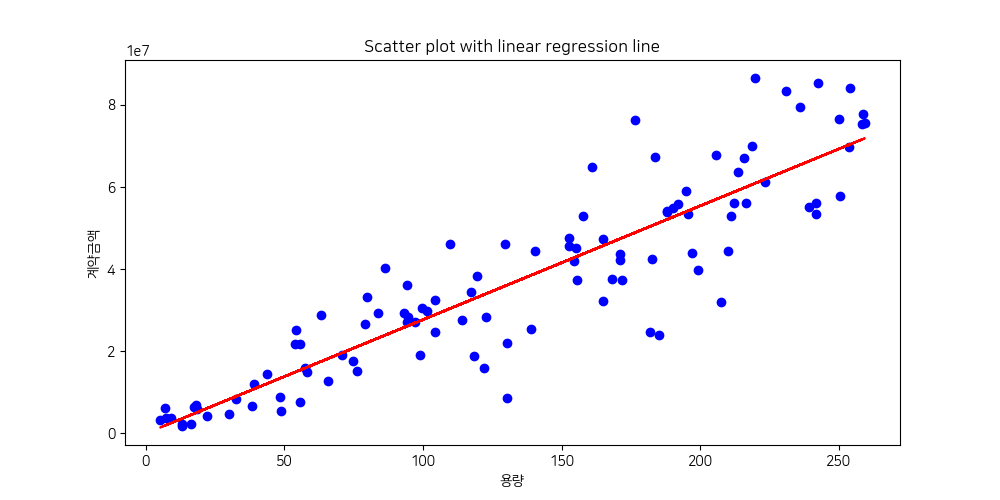

In [ ]:
# create a linear regression model
reg, data_outlier = getLinearRegression(x_column='용량', y_column='계약금액', data=data_gas)
# draw a linaer line
%matplotlib widget
drawLinearRegressionPlot(regression_model=reg, x_column='용량', y_column='계약금액', data=data_outlier)

Intercept: [0.25357835]
Coefficient: [6.06730853e-05]


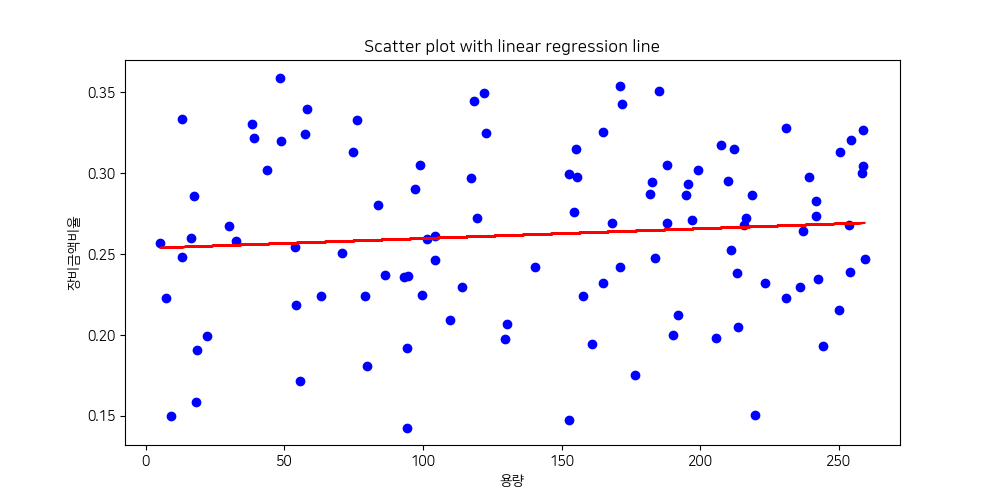

In [ ]:
# create a linear regression model
reg, data_outlier = getLinearRegression(x_column='용량', y_column='장비금액비율', data=data_gas)
# draw a linaer line
%matplotlib widget
drawLinearRegressionPlot(regression_model=reg, x_column='용량', y_column='장비금액비율', data=data_outlier)

In [ ]:
# create boxplot
stats = data_outlier.groupby('수요기관지역명').agg({'장비금액비율': ['mean'], '계약금액':['mean']})
print(stats)

           장비금액비율          계약금액
             mean          mean
수요기관지역명                        
강원도      0.289925  4.791097e+07
경기도      0.245436  4.140370e+07
경상남도     0.246665  4.086408e+07
경상북도     0.214437  4.441824e+07
대구광역시    0.261923  4.108938e+07
대전광역시    0.288480  2.767056e+07
부산광역시    0.279636  4.611153e+07
서울특별시    0.252723  4.174191e+07
울산광역시    0.299838  2.003237e+07
인천광역시    0.230052  5.933300e+07
전라남도     0.238281  3.962970e+07
전라북도     0.276495  3.441580e+07
충청남도     0.314892  4.504399e+07
충청북도     0.291238  2.888118e+07


Intercept: [6579968.28070211]
Coefficient: [242857.66692954]


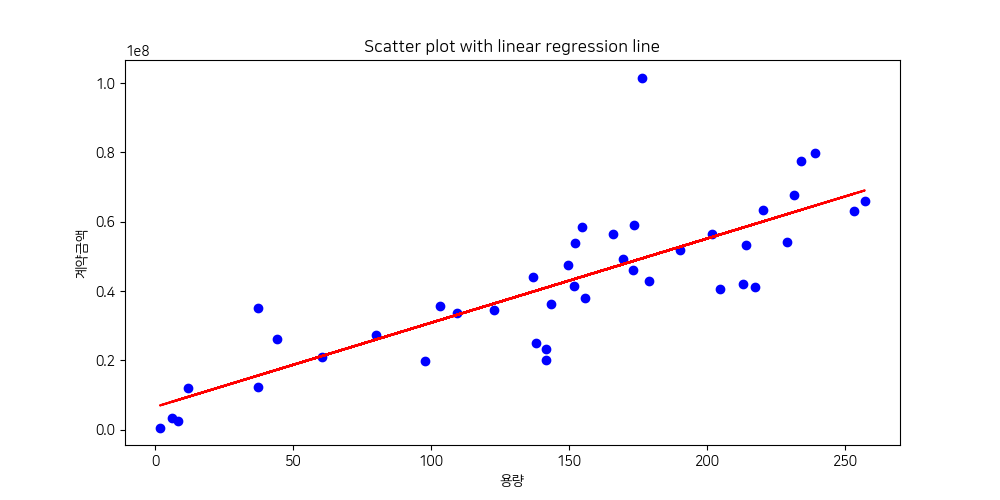

In [ ]:
# create a linear regression model
reg, data_outlier = getLinearRegression(x_column='용량', y_column='계약금액', data=data_geo)
# draw a linaer line
%matplotlib widget
drawLinearRegressionPlot(regression_model=reg, x_column='용량', y_column='계약금액', data=data_outlier)

Intercept: [0.21237795]
Coefficient: [0.00027568]


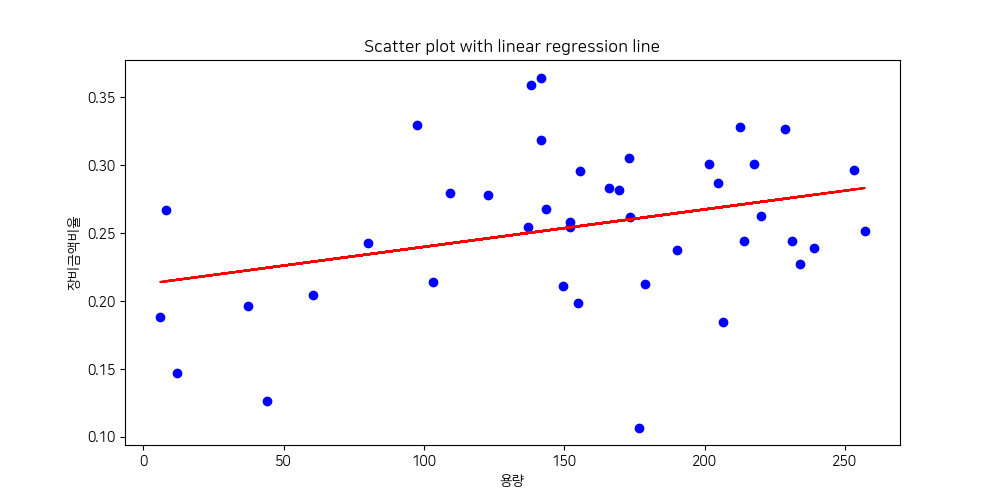

In [ ]:
# create a linear regression model
reg, data_outlier = getLinearRegression(x_column='용량', y_column='장비금액비율', data=data_geo)
# draw a linaer line
%matplotlib widget
drawLinearRegressionPlot(regression_model=reg, x_column='용량', y_column='장비금액비율', data=data_outlier)

In [ ]:
# create boxplot
stats = data_outlier.groupby('수요기관지역명').agg({'장비금액비율': ['mean'], '계약금액':['mean']})
print(stats)

           장비금액비율         계약금액
             mean         mean
수요기관지역명                       
강원도      0.233061  63350740.00
경기도      0.240944  37589641.25
경상남도     0.241830  66548890.00
경상북도     0.251850  65963820.00
광주광역시    0.244255  67560500.00
대전광역시    0.188493   3411260.00
부산광역시    0.299661  37822812.50
서울특별시    0.246324  47293850.00
세종특별자치시  0.278968  61096440.00
인천광역시    0.279559  33774630.00
전라남도     0.262330  33203500.00
전라북도     0.147393  11974760.00
충청남도     0.284135  51693105.00
충청북도     0.259148  49745748.00
